![alt text](output.png)

### projekt and llm setup

In [528]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\djadh\Downloads\auto-research-report


In [529]:
from research_and_analyst.utils.model_loader import ModelLoader

In [530]:
model_loader = ModelLoader()

{"timestamp": "2025-10-19T10:05:36.497864Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-19T10:05:36.499864Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-19T10:05:36.500859Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-19T10:05:36.502859Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-19T10:05:36.503859Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-19T10:05:36.509859Z", "level": "info", "event": "YAML config loaded"}


In [531]:
llm=model_loader.load_llm()

{"provider": "groq", "model": "llama-3.3-70b-versatile", "timestamp": "2025-10-19T10:05:36.530859Z", "level": "info", "event": "Loading LLM"}


In [532]:
llm.invoke("hi").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


"It's nice to meet you. Is there something I can help you with or would you like to chat?"

### importlib

In [534]:
import os
import operator
from typing import List
from langgraph.types import Send
from IPython.display import Markdown
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import WikipediaLoader
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import get_buffer_string
from dotenv import load_dotenv
load_dotenv()

True

## First Workflow

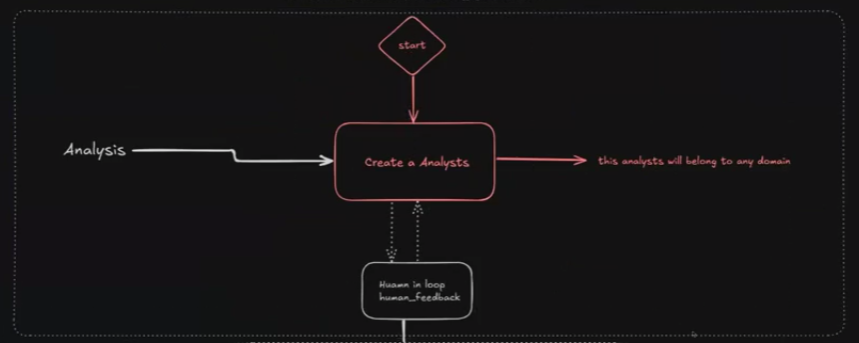

#### State buidling

In [535]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

try analyst

In [536]:
analyst = Analyst(
    name="billu",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [537]:
analyst.name , analyst.role , analyst.description

('billu', 'genai eng', 'I am genai developer as well as mentor')

In [538]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [539]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

try state

In [540]:
a = GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

In [541]:
a.get("human_analyst_feedback")

'give the real info'

#### prompt template

In [542]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

try prompt placeholder

In [543]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n        \n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n        \nplease exaplain only on AI\n    \n3. Determine the most interesting themes based upon documents and / or feedback above.\n                    \n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


#### nodes

In [544]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )
    
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

try "create_analyst" node

In [545]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Rachel Kim', role='Healthcare Specialist', affiliation='Johns Hopkins University', description='Focus on preventative care, concerned about healthcare accessibility, and motivated to improve health outcomes.'),
  Analyst(name='Dr. Liam Chen', role='Medical Researcher', affiliation='Harvard Medical School', description='Focus on medical advancements, concerned about the impact of new technologies on healthcare, and motivated to discover innovative treatments.')]}

In [546]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

check if the human feed has the words like 

"none", "skip", "done", "continue"

if not then create analyst , else END

In [547]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

#### graph budiling

In [548]:
builder = StateGraph(GenerateAnalystsState)

In [549]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [550]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [551]:
memory = MemorySaver()

In [552]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

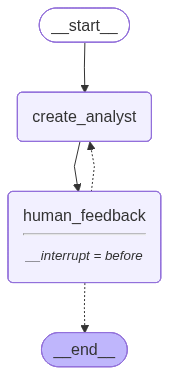

In [553]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

#### test

In [554]:
topic = "the drawbacks of adopting n8n as an agent framework"

In [555]:
max_analysts = 2

In [556]:
thread =  {"configurable":{"thread_id":1}}

In [557]:
for event in graph.stream({"topic":topic,
            "max_analysts":max_analysts},
            thread,
            stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Alex Chen
Affiliation: n8n Community
Role: Technical Architect
Description: Focus on the technical limitations and potential workarounds of n8n as an agent framework, with concerns about scalability and performance.
--------------------------------------------------
Name: Maya Patel
Affiliation: Enterprise Software Company
Role: Integration Specialist
Description: Concerned with the integration challenges and potential drawbacks of using n8n, such as compatibility issues and lack of support for certain protocols.
--------------------------------------------------


In [558]:
state = graph.get_state(thread)

In [559]:
state

StateSnapshot(values={'topic': 'the drawbacks of adopting n8n as an agent framework', 'max_analysts': 2, 'analysts': [Analyst(name='Alex Chen', role='Technical Architect', affiliation='n8n Community', description='Focus on the technical limitations and potential workarounds of n8n as an agent framework, with concerns about scalability and performance.'), Analyst(name='Maya Patel', role='Integration Specialist', affiliation='Enterprise Software Company', description='Concerned with the integration challenges and potential drawbacks of using n8n, such as compatibility issues and lack of support for certain protocols.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0acd32-c914-64ac-8001-77a3b9a4bbd9'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-19T10:05:43.428010+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0acd32-c453-691b-8000-3471c43d

In [560]:
state.values

{'topic': 'the drawbacks of adopting n8n as an agent framework',
 'max_analysts': 2,
 'analysts': [Analyst(name='Alex Chen', role='Technical Architect', affiliation='n8n Community', description='Focus on the technical limitations and potential workarounds of n8n as an agent framework, with concerns about scalability and performance.'),
  Analyst(name='Maya Patel', role='Integration Specialist', affiliation='Enterprise Software Company', description='Concerned with the integration challenges and potential drawbacks of using n8n, such as compatibility issues and lack of support for certain protocols.')]}

In [561]:
state.values

{'topic': 'the drawbacks of adopting n8n as an agent framework',
 'max_analysts': 2,
 'analysts': [Analyst(name='Alex Chen', role='Technical Architect', affiliation='n8n Community', description='Focus on the technical limitations and potential workarounds of n8n as an agent framework, with concerns about scalability and performance.'),
  Analyst(name='Maya Patel', role='Integration Specialist', affiliation='Enterprise Software Company', description='Concerned with the integration challenges and potential drawbacks of using n8n, such as compatibility issues and lack of support for certain protocols.')]}

check current state

In [562]:
state.next

('human_feedback',)

In [563]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0acd32-c451-620e-bfff-6b09cbdcafe3': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-19T10:05:42.928641+00:00\xa2id\xd9$1f0acd32-c451-620e-bfff-6b09cbdcafe3\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.7128505738015353\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0acd32-c453-691b-8000-3471c43d9ba0': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-19T10:05:42.929641+00:00\xa2id\xd9$1f0acd32-c453-691b-8000-3471c43d9ba0\xb0channel_versions\x84\xa9__start__\xd9400000000000000000000000000000002.0.34418633004570565\xa5topic\xd9400000000000000000000000000000002.0.34418633004570565\xacmax_analysts\xd9400000000000000000000000000000002.0.34418633004570565\xb8branch:to:create_analyst\xd9400000000000000000000000000000002.0.34418633004570565\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start_

In [564]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0acd32-c914-64ac-8001-77a3b9a4bbd9'}}

move to next state

In [565]:
graph.update_state(thread,
                {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
        )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0acd32-ca6e-6d62-8002-654b66900752'}}

In [566]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Chen
Affiliation: n8n Community
Role: Technical Architect
Description: Focus on the technical limitations and potential workarounds of n8n as an agent framework, with concerns about scalability and performance.
--------------------------------------------------
Name: Maya Patel
Affiliation: Enterprise Software Company
Role: Integration Specialist
Description: Concerned with the integration challenges and potential drawbacks of using n8n, such as compatibility issues and lack of support for certain protocols.
--------------------------------------------------


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Alex Chen
Affiliation: n8n Startup
Role: Technical Lead
Description: Focus on the technical drawbacks of adopting n8n as an agent framework, such as scalability and integration issues, from a startup perspective.
--------------------------------------------------
Name: Maya Patel
Affiliation: Enterprise Application Consulting
Role: Enterprise Architect
Description: Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.
--------------------------------------------------


In [567]:
state = graph.get_state(thread)

In [568]:
state.next

('human_feedback',)

In [569]:
state.values

{'topic': 'the drawbacks of adopting n8n as an agent framework',
 'max_analysts': 2,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Alex Chen', role='Technical Lead', affiliation='n8n Startup', description='Focus on the technical drawbacks of adopting n8n as an agent framework, such as scalability and integration issues, from a startup perspective.'),
  Analyst(name='Maya Patel', role='Enterprise Architect', affiliation='Enterprise Application Consulting', description='Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.')]}

In [570]:
further_feedack = ""

In [571]:
state = graph.get_state(thread)
cfg = state.config

In [572]:
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0acd32-d022-6cdc-8006-1c2223b2623a'}}

In [573]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

()


In [574]:
analysts = final_state.values.get('analysts')

In [575]:
analysts

[Analyst(name='Alex Chen', role='Technical Lead', affiliation='n8n Startup', description='Focus on the technical drawbacks of adopting n8n as an agent framework, such as scalability and integration issues, from a startup perspective.'),
 Analyst(name='Maya Patel', role='Enterprise Architect', affiliation='Enterprise Application Consulting', description='Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.')]

In [576]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alex Chen
Affiliation: n8n Startup
Role: Technical Lead
Description: Focus on the technical drawbacks of adopting n8n as an agent framework, such as scalability and integration issues, from a startup perspective.
--------------------------------------------------
Name: Maya Patel
Affiliation: Enterprise Application Consulting
Role: Enterprise Architect
Description: Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.
--------------------------------------------------


---

## SECOND WORKFLOW

#### defining the main state of the second workflow

In [577]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

### web search config

##### wiki

In [578]:
# docs = WikipediaLoader(query="ML").load()
# print(docs[0].page_content[:50])

#### tavily

Either you can use Google Serper API or use duckduckgo

In [579]:
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [580]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [581]:
tavily_search.invoke("ML")

[{'title': 'What is Machine Learning? Definition, Types, Tools & More',
  'url': 'https://www.datacamp.com/blog/what-is-machine-learning',
  'content': 'Machine Learning, often abbreviated as ML, is a subset of artificial intelligence (AI) that focuses on the development of computer algorithms that improve automatically through experience and by the use of data. In simpler terms, machine learning enables computers to learn from data and make decisions or predictions without being explicitly programmed to do so. [...] Machine learning is a subset of AI, which uses algorithms that learn from data to make predictions. These predictions can be generated through supervised learning, where algorithms learn patterns from existing data, or unsupervised learning, where they discover general patterns in data. ML models can predict numerical values based on historical data, categorize events as true or false, and cluster data points based on commonalities. [...] At its core, machine learning is a

### defining prompt templates and nodes

### prompts for nodes

In [582]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [583]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n        \n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Maya Patel\nRole: Enterprise Architect\nAffiliation: Enterprise Application Consulting\nDescription: Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.\n\n        \nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n        \nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember 

In [584]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [585]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [586]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

### nodes 

##### generate question 

In [587]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke(
        [SystemMessage(content=system_message)]+messages
    )
    
    #returen the question through state
    return {"messages":[question]}

tryout

In [588]:
analyst

Analyst(name='Maya Patel', role='Enterprise Architect', affiliation='Enterprise Application Consulting', description='Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.')

passing state

In [589]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [590]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Maya Patel', role='Enterprise Architect', affiliation='Enterprise Application Consulting', description='Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

##### search web

In [591]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    # parsing tavily results and preserve the url
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

tryout

passing state

In [592]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [593]:
result = search_web(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


results

In [594]:
print(result["context"][0])

<Document href="https://blog.agen.cy/p/agency-revolutionizing-ai-development"/>
As the AI agent ecosystem continues to evolve, LangGraph is positioned to become the standard for sophisticated, stateful agent systems. Agency is leading the way in developing innovative applications that leverage this powerful framework to solve complex business challenges. [...] LangGraph represents a significant advancement in the LangChain ecosystem, specifically designed for creating and managing complex agent workflows. Unlike traditional frameworks that struggle with maintaining state and handling cyclical processes, LangGraph introduces a graph-based approach that enables AI agents to revisit previous steps, adapt to changing conditions, and maintain context throughout extended interactions. [...] #

In the rapidly evolving landscape of AI agent development, LangGraph has emerged as a powerful framework for building sophisticated, stateful multi-agent systems. As organizations seek to harness the f

#### Search wikipedia

In [595]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

tryout

passing state

In [596]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [597]:
result = search_wikipedia(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='What is Langgraph and its significance for business innovation'


no results , dont know why

In [598]:
print(result["context"][0])

#### Generate answer

In [599]:
def generate_answer(state:InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

#### Save Interview

In [600]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

#### Write section

In [601]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


#### router

In [602]:
def route_messages(state: InterviewState, 
                name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

### STATE building

#### Buidling 

In [603]:
interview_builder = StateGraph(InterviewState)

In [604]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [605]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                            route_messages,
                            ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [606]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

previous workflow recap

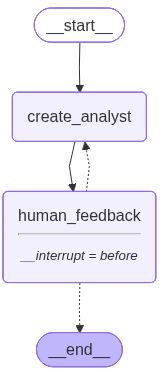

now this workflow

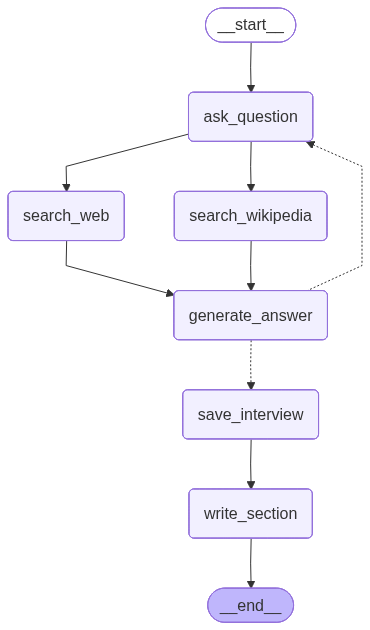

In [607]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

#### testing workflow

In [608]:
analyst

Analyst(name='Maya Patel', role='Enterprise Architect', affiliation='Enterprise Application Consulting', description='Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.')

In [609]:
analyst.persona

'Name: Maya Patel\nRole: Enterprise Architect\nAffiliation: Enterprise Application Consulting\nDescription: Examine the drawbacks of adopting n8n as an agent framework in the context of the latest enterprise applications, including security and compliance concerns.\n'

In [610]:
thread = {"configurable": {"thread_id": "1"}}

In [611]:
messages = [HumanMessage("So you said you were writing an article on n8n and Autogen compare?")]

In [612]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='n8n security concerns enterprise applications'


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='n8n enterprise security compliance concerns and mitigation strategies'


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 5.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [613]:
Markdown(interview['sections'][0])

## Drawbacks of Adopting n8n as an Agent Framework
### Summary
The adoption of n8n as an agent framework in enterprise applications has several drawbacks, particularly in terms of security and compliance concerns. While n8n can be a powerful automation platform, its strength lies in how responsibly it's configured and maintained [1]. Security should not be a reactive measure; it must be part of every design decision, every deployment, and every workflow execution. According to various sources, including [2] and [3], n8n can be used in enterprise environments if deployed with best practices such as VPN access, encrypted storage, and integration with secrets managers. However, the platform's security practices must be carefully implemented to ensure the integrity of operations. Some of the key concerns include:
1. **Security vulnerabilities**: n8n's connections to numerous third-party services via APIs represent potential attack vectors that must be carefully scrutinized [4].
2. **Compliance risks**: n8n workflows often process sensitive data, interact with critical systems, and execute privileged operations, making them potential security vulnerability points if not properly secured [5].
3. **Incident response**: Collaboration between security teams, developers, and stakeholders is vital to address vulnerabilities and maintain trust in the automation platform [6].
4. **Governance practices**: Establishing clear compliance boundaries, data classification mechanisms, and compliance validation checks can help ensure that enterprise-wide n8n implementations maintain appropriate quality, security, and performance characteristics [7].

### Sources
[1] https://www.soraia.io/blog/n8n-security-best-practices-protect-your-data-and-workflows 
[2] https://medium.com/@dejanmarkovic_53716/top-n8n-productivity-tips-for-enterprise-success-6c412d2a8979 
[3] https://dev.to/alifar/n8n-at-scale-enterprise-governance-and-secure-automation-1jih 
[4] https://www.wednesday.is/writing-articles/n8n-security-protecting-your-automation-workflows 
[5] https://medium.com/@dejanmarkovic_53716/elevate-your-business-with-n8n-workflow-optimization-da8b6b28042c 
[6] https://www.wednesday.is/writing-articles/n8n-security-protecting-your-automation-workflows 
[7] https://scalevise.com/resources/n8n-enterprise-automation/ 
[8] https://n8n.io/legal/security/ 
[9] https://jimmysong.io/en/blog/n8n-deep-dive/

## Third Workflow

#### Class Building

In [614]:
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

#### prompt templates

In [615]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [616]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

#### Nodes

##### INITIATE interviews

In [617]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                ]}) for analyst in state["analysts"]]


##### write report

In [618]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

##### write introduction

In [619]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

##### write conclusion

In [620]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

##### finalize report

In [621]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

#### graph budiling

In [622]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [623]:
memory = MemorySaver()

In [624]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

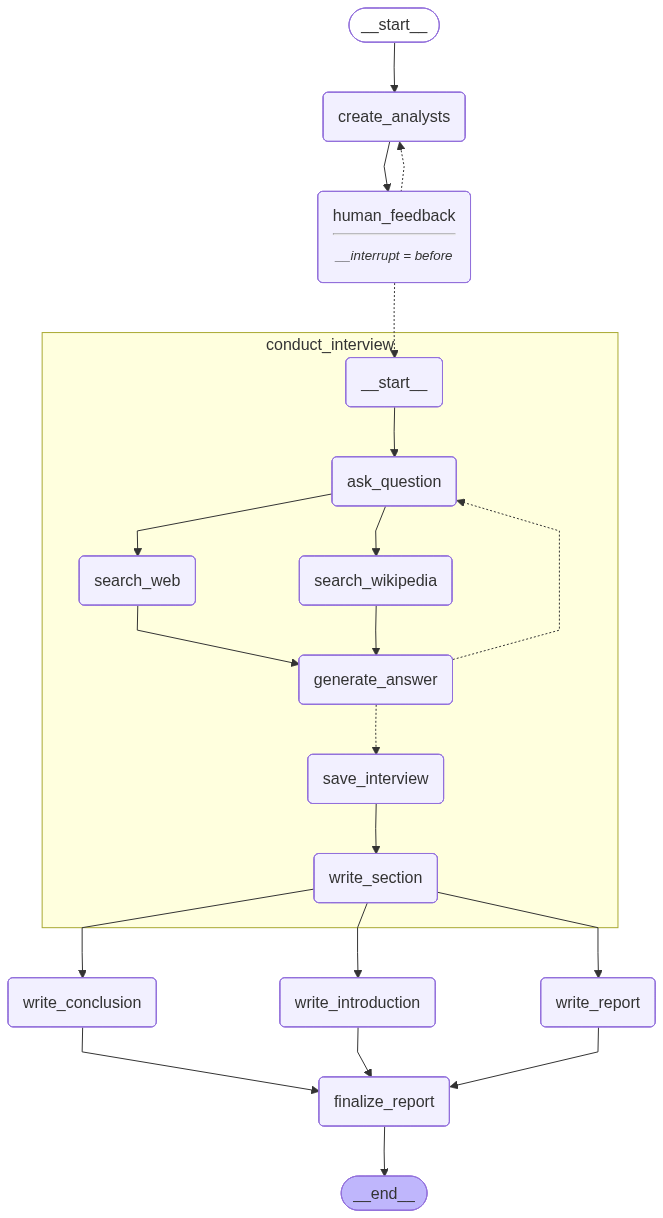

In [625]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Running the final flow

In [626]:
max_analysts = 2

In [627]:
topic = "How can generative help us to have a better word rhyme play for rapping"

In [628]:
thread = {"configurable": {"thread_id": "5"}}

In [629]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 2.000000 seconds


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Linguist Lucy
Affiliation: University of Language Arts
Role: Language Specialist
Description: Focuses on the application of generative models to improve word rhyme play in rapping, with a concern for linguistic accuracy and creativity.
--------------------------------------------------
Name: Music Maverick Max
Affiliation: BeatDrop Music Studio
Role: Music Producer
Description: Examines the potential of generative models to enhance rhythm and flow in rap music, with a motive to push the boundaries of musical expression.
--------------------------------------------------


In [630]:
state = graph.get_state(thread)

In [631]:
state.next

('human_feedback',)

In [632]:
graph.update_state(thread, {"human_analyst_feedback":"along with the generative ai in future tell me the future of indian rap culture"}, as_node="human_feedback")

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0acd33-abb5-6235-8002-da3a4ae25464'}}

In [633]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Linguist Lucy
Affiliation: University of Language Arts
Role: Language Specialist
Description: Focuses on the application of generative models to improve word rhyme play in rapping, with a concern for linguistic accuracy and creativity.
--------------------------------------------------
Name: Music Maverick Max
Affiliation: BeatDrop Music Studio
Role: Music Producer
Description: Examines the potential of generative models to enhance rhythm and flow in rap music, with a motive to push the boundaries of musical expression.
--------------------------------------------------


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 2.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Rahul Rao
Affiliation: Rolling Stone India
Role: Music Critic
Description: Focus on the evolution of Indian rap culture, its current trends, and the potential impact of generative AI on the genre.
--------------------------------------------------
Name: Aisha Ali
Affiliation: Indian Institute of Technology
Role: AI Researcher
Description: Examine the technical aspects of generative AI and its applications in creating innovative word rhyme plays for rapping, with a focus on the future of Indian rap culture.
--------------------------------------------------


In [634]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0acd33-c483-6ce0-8006-f8153684f873'}}

In [635]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview')

In [636]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 2.000000 seconds
Retrying request to /openai/v1/chat/completions in 2.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 1.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 2.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 2.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jtznywrffxya7zs8233saw7g` service tier `on_demand` on tokens per minute (TPM): Limit 12000, Used 11820, Requested 441. Please try again in 1.305s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
final_state = graph.get_state(thread)

In [ ]:
report = final_state.values.get('final_report')

In [ ]:
Markdown(report)

<IPython.core.display.Markdown object>